In [18]:
#geral
import pandas as pd
import numpy as np

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#visual
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pp
from datasets import load_metric
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [2]:
df = pd.read_csv('data/all_data.csv')

In [3]:
df

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by ...,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\...",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999511,1018736,Another man shamming article. If white men did...,train,2017-02-20 07:20:49.964620+00,54,NaN,169202,approved,0,0,...,0.8,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,10,10
1999512,340016,"""no matter what is put in front of you regardi...",train,2016-06-06 06:43:04.780968+00,21,339965.0,137961,approved,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,10,10
1999513,919629,The Democrat party aided and abetted by it's M...,train,2017-01-30 02:44:29.168863+00,54,NaN,164845,rejected,0,1,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,11,10
1999514,5165492,I just don't find her a very good representati...,train,2017-04-22 18:42:02.442987+00,54,NaN,328877,approved,1,0,...,0.0,0.0,0.0,0.0,0.003717,0.0,0.0,0.00000,269,10


In [4]:
df.isnull().sum()

id                                           0
comment_text                                 1
split                                        0
created_date                                 0
publication_id                               0
parent_id                               864807
article_id                                   0
rating                                       0
funny                                        0
wow                                          0
sad                                          0
likes                                        0
disagree                                     0
toxicity                                     0
severe_toxicity                              0
obscene                                      0
sexual_explicit                              0
identity_attack                              0
insult                                       0
threat                                       0
male                                   1551516
female       

In [5]:
df.dropna(subset=['comment_text', 'toxicity'], inplace=True)
df.dropna(axis='columns', inplace=True)
print(df.shape)
df.isnull().sum()

(1999515, 21)


id                          0
comment_text                0
split                       0
created_date                0
publication_id              0
article_id                  0
rating                      0
funny                       0
wow                         0
sad                         0
likes                       0
disagree                    0
toxicity                    0
severe_toxicity             0
obscene                     0
sexual_explicit             0
identity_attack             0
insult                      0
threat                      0
identity_annotator_count    0
toxicity_annotator_count    0
dtype: int64

In [7]:
# remove duplicados
df.drop_duplicates(subset=['comment_text',], keep='first', inplace=True)
df.shape # 1999515 - 1971915 = 27600 duplicados

(1971915, 21)

In [8]:
df.comment_text = df.comment_text.replace('\xad', '', regex=True)  # remove os caracteres \xad que aparecem em alguns spams


<AxesSubplot:xlabel='toxicity', ylabel='Density'>

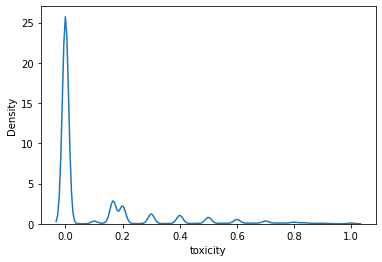

In [9]:
sns.kdeplot(df.toxicity)

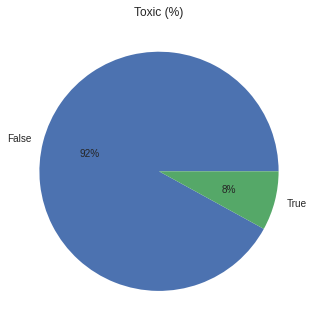

In [10]:
plt.style.use('seaborn')
#create pie chart
count_toxic = (df.toxicity >= 0.5).value_counts()
plt.pie(count_toxic, labels=count_toxic.index, autopct='%.0f%%')
plt.title("Toxic (%)")
plt.show()

<AxesSubplot:xlabel='comment_text', ylabel='Density'>

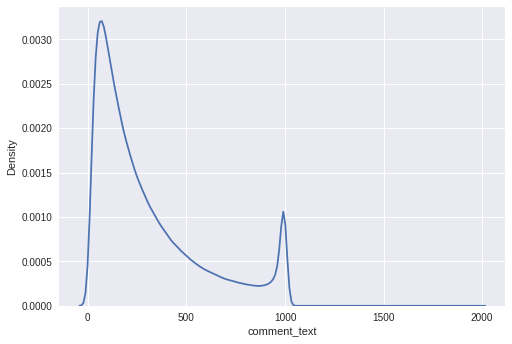

In [11]:
sns.kdeplot(df.comment_text.str.len())

In [12]:
df['label'] = np.where(df['toxicity'] >= 0.5, 1, 0)

In [13]:
from datasets import Dataset, DatasetDict
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


X = df.comment_text.to_numpy().reshape(-1,1)
y = np.where(df[['toxicity']] >= 0.5, 1, 0).reshape(-1,1)

under_sampler = RandomUnderSampler(random_state=0)
X, y = under_sampler.fit_resample(X, y)

raw_datasets = Dataset.from_dict({
    'comment_text': X.ravel(),
    'label': y,
}).train_test_split(train_size=0.9, test_size=0.1)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'label'],
        num_rows: 283813
    })
    test: Dataset({
        features: ['comment_text', 'label'],
        num_rows: 31535
    })
})

In [14]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_metric

checkpoint = 'toxicity/checkpoint-189210'
# checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


def tokenize_function(example):
    return tokenizer(example["comment_text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


  0%|          | 0/284 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    "toxicity", 
    per_device_train_batch_size=3, 
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=2,
    save_total_limit=5,
    save_strategy='epoch',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [15]:
# trainer.train()

In [16]:
from datasets import load_metric
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 31535
  Batch size = 8


(31535, 2) (31535,)


{'accuracy': 0.8973204376090058, 'f1': 0.9006748466257669}

In [17]:
confusion_matrix(tokenized_datasets["test"]["label"], preds)

array([[13616,  2071],
       [ 1167, 14681]])

In [18]:
from pprint import pp

pp(classification_report(tokenized_datasets["test"]["label"], preds, output_dict=True))

{'0': {'precision': 0.921057971994859,
       'recall': 0.8679798559316632,
       'f1-score': 0.8937315392189039,
       'support': 15687},
 '1': {'precision': 0.876372970391595,
       'recall': 0.9263629480060576,
       'f1-score': 0.9006748466257669,
       'support': 15848},
 'accuracy': 0.8973204376090058,
 'macro avg': {'precision': 0.898715471193227,
               'recall': 0.8971714019688604,
               'f1-score': 0.8972031929223354,
               'support': 31535},
 'weighted avg': {'precision': 0.8986014029316426,
                  'recall': 0.8973204376090058,
                  'f1-score': 0.8972209172364706,
                  'support': 31535}}


In [28]:
inputs = tokenizer("I'm a gay woman", padding=True, truncation=True, max_length=512, return_tensors='pt',).to(model.device)
model(**inputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-3.9288,  3.4672]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [23]:
tokenizer.decode(tokenized_datasets['train']['input_ids'][0])

'[CLS] " Conservatives felt strongly that hanging four men out to die in Benghazi was despicable and we have been severely ridiculed for taking a principled stand. " No, you\'re ridiculed for your nonstop efforts to use the blood of those men for political gain, when even Republican witch - hunt investigations could find no proof that anything would have changed the outcome that day, and yet you hypocritically say not a peep about all the attacks and deaths on US diplomatic facilities and personnel that happened under Republican administrations. There is nothing principled about your position. [SEP]'

In [22]:
# Validação 

test_df = df[df['split'] == 'test']

test_dataset = Dataset.from_dict({
    'comment_text': test_df['comment_text'],
    'label': test_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tokenized_test["label"], preds))
pp(classification_report(tokenized_test["label"], preds, output_dict=True))

  0%|          | 0/192 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 191787
  Batch size = 8


(191787, 2) (191787,)
array([[153415,  23129],
       [   825,  14418]])
{'0': {'precision': 0.9946511929460581,
       'recall': 0.8689901667572957,
       'f1-score': 0.9275841636838542,
       'support': 176544},
 '1': {'precision': 0.3839987216022585,
       'recall': 0.9458767959063177,
       'f1-score': 0.5462398181473764,
       'support': 15243},
 'accuracy': 0.8751010235313134,
 'macro avg': {'precision': 0.6893249572741583,
               'recall': 0.9074334813318067,
               'f1-score': 0.7369119909156153,
               'support': 191787},
 'weighted avg': {'precision': 0.9461172692666975,
                  'recall': 0.8751010235313134,
                  'f1-score': 0.8972753739378728,
                  'support': 191787}}


# ANÁLISE DE VIÉS

In [23]:
# recarrega dataset
bdf = pd.read_csv('data/all_data.csv')
bdf.dropna(subset=['comment_text', 'toxicity'], inplace=True)
# df.dropna(axis='columns', inplace=True)
# remove duplicados
bdf.drop_duplicates(subset=['comment_text',], keep='first', inplace=True)
bdf.comment_text = bdf.comment_text.replace('\xad', '', regex=True)  # remove os caracteres \xad que aparecem em alguns spams
bdf.isnull().sum()
bdf = bdf.dropna(subset=['male',])
bdf['label'] = np.where(bdf['toxicity'] >= 0.5, 1, 0)


In [24]:
# Análise Bias - Male

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['male'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 4363
  Batch size = 8


array([[2571, 1126],
       [  27,  639]])
{'0': {'precision': 0.9896073903002309,
       'recall': 0.6954287259940493,
       'f1-score': 0.8168387609213662,
       'support': 3697},
 '1': {'precision': 0.3620396600566572,
       'recall': 0.9594594594594594,
       'f1-score': 0.5257095845331139,
       'support': 666},
 'accuracy': 0.7357322942929178,
 'macro avg': {'precision': 0.6758235251784441,
               'recall': 0.8274440927267543,
               'f1-score': 0.67127417272724,
               'support': 4363},
 'weighted avg': {'precision': 0.893810895149596,
                  'recall': 0.7357322942929178,
                  'f1-score': 0.7723986895313649,
                  'support': 4363}}


In [25]:
# Análise Bias - Female

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['female'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/6 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 5138
  Batch size = 8


array([[3218, 1231],
       [  36,  653]])
{'0': {'precision': 0.9889366933005531,
       'recall': 0.723308608676107,
       'f1-score': 0.8355186291055432,
       'support': 4449},
 '1': {'precision': 0.3466029723991507,
       'recall': 0.9477503628447025,
       'f1-score': 0.5075787019043918,
       'support': 689},
 'accuracy': 0.7534059945504087,
 'macro avg': {'precision': 0.6677698328498519,
               'recall': 0.8355294857604048,
               'f1-score': 0.6715486655049675,
               'support': 5138},
 'weighted avg': {'precision': 0.902800466422183,
                  'recall': 0.7534059945504087,
                  'f1-score': 0.7915422550608578,
                  'support': 5138}}


In [26]:
# Análise Bias - homosexual_gay_or_lesbian

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['homosexual_gay_or_lesbian'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 1064
  Batch size = 8


array([[273, 502],
       [ 10, 279]])
{'0': {'precision': 0.9646643109540636,
       'recall': 0.352258064516129,
       'f1-score': 0.5160680529300566,
       'support': 775},
 '1': {'precision': 0.35723431498079383,
       'recall': 0.9653979238754326,
       'f1-score': 0.5214953271028037,
       'support': 289},
 'accuracy': 0.518796992481203,
 'macro avg': {'precision': 0.6609493129674286,
               'recall': 0.6588279941957808,
               'f1-score': 0.5187816900164302,
               'support': 1064},
 'weighted avg': {'precision': 0.7996762763335044,
                  'recall': 0.518796992481203,
                  'f1-score': 0.5175421903698347,
                  'support': 1064}}


In [27]:
# Análise Bias - christian

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['christian'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 4198
  Batch size = 8


array([[3025,  759],
       [  27,  387]])
{'0': {'precision': 0.9911533420707732,
       'recall': 0.7994186046511628,
       'f1-score': 0.8850204798127561,
       'support': 3784},
 '1': {'precision': 0.337696335078534,
       'recall': 0.9347826086956522,
       'f1-score': 0.4961538461538461,
       'support': 414},
 'accuracy': 0.8127679847546451,
 'macro avg': {'precision': 0.6644248385746536,
               'recall': 0.8671006066734075,
               'f1-score': 0.6905871629833011,
               'support': 4198},
 'weighted avg': {'precision': 0.926710464296884,
                  'recall': 0.8127679847546451,
                  'f1-score': 0.846671078589605,
                  'support': 4198}}


In [28]:
# Análise Bias - jewish

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['jewish'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 831
  Batch size = 8


array([[436, 258],
       [  6, 131]])
{'0': {'precision': 0.9864253393665159,
       'recall': 0.6282420749279539,
       'f1-score': 0.7676056338028171,
       'support': 694},
 '1': {'precision': 0.33676092544987146,
       'recall': 0.9562043795620438,
       'f1-score': 0.49809885931558934,
       'support': 137},
 'accuracy': 0.6823104693140795,
 'macro avg': {'precision': 0.6615931324081936,
               'recall': 0.7922232272449989,
               'f1-score': 0.6328522465592032,
               'support': 831},
 'weighted avg': {'precision': 0.879320616494578,
                  'recall': 0.6823104693140795,
                  'f1-score': 0.7231743123771249,
                  'support': 831}}


In [29]:
# Análise Bias - muslim

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['muslim'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 2013
  Batch size = 8


array([[697, 837],
       [ 18, 461]])
{'0': {'precision': 0.9748251748251748,
       'recall': 0.45436766623207303,
       'f1-score': 0.6198310360160072,
       'support': 1534},
 '1': {'precision': 0.3551617873651772,
       'recall': 0.9624217118997912,
       'f1-score': 0.5188519977490151,
       'support': 479},
 'accuracy': 0.5752608047690015,
 'macro avg': {'precision': 0.664993481095176,
               'recall': 0.7083946890659321,
               'f1-score': 0.5693415168825111,
               'support': 2013},
 'weighted avg': {'precision': 0.8273742247042912,
                  'recall': 0.5752608047690015,
                  'f1-score': 0.5958027402733895,
                  'support': 2013}}


In [30]:
# Análise Bias - black

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['black'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 1507
  Batch size = 8


array([[285, 726],
       [  8, 488]])
{'0': {'precision': 0.9726962457337884,
       'recall': 0.2818991097922849,
       'f1-score': 0.4371165644171779,
       'support': 1011},
 '1': {'precision': 0.40197693574958815,
       'recall': 0.9838709677419355,
       'f1-score': 0.5707602339181287,
       'support': 496},
 'accuracy': 0.5129396151293961,
 'macro avg': {'precision': 0.6873365907416883,
               'recall': 0.6328850387671102,
               'f1-score': 0.5039383991676533,
               'support': 1507},
 'weighted avg': {'precision': 0.7848549864423727,
                  'recall': 0.5129396151293961,
                  'f1-score': 0.4811028020233302,
                  'support': 1507}}


In [31]:
# Análise Bias - white

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['white'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 2428
  Batch size = 8


array([[ 539, 1156],
       [   9,  724]])
{'0': {'precision': 0.9835766423357665,
       'recall': 0.31799410029498526,
       'f1-score': 0.48060633080695503,
       'support': 1695},
 '1': {'precision': 0.3851063829787234,
       'recall': 0.9877216916780355,
       'f1-score': 0.5541523153463451,
       'support': 733},
 'accuracy': 0.520181219110379,
 'macro avg': {'precision': 0.684341512657245,
               'recall': 0.6528578959865103,
               'f1-score': 0.5173793230766501,
               'support': 2428},
 'weighted avg': {'precision': 0.8029017246633149,
                  'recall': 0.520181219110379,
                  'f1-score': 0.5028094637012602,
                  'support': 2428}}


In [32]:
# Análise Bias - psychiatric_or_mental_illness

tbias_df = bdf[bdf['split'] == 'test']
tbias_df = tbias_df[tbias_df['psychiatric_or_mental_illness'] >= 0.5]

test_dataset = Dataset.from_dict({
    'comment_text': tbias_df['comment_text'],
    'label': tbias_df['label'],
})
tokenized_test = test_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_test)

preds = np.argmax(predictions.predictions, axis=-1)

pp(confusion_matrix(tbias_df["label"], preds))
pp(classification_report(tbias_df["label"], preds, output_dict=True))

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text.
***** Running Prediction *****
  Num examples = 508
  Batch size = 8


array([[274, 130],
       [  7,  97]])
{'0': {'precision': 0.9750889679715302,
       'recall': 0.6782178217821783,
       'f1-score': 0.8,
       'support': 404},
 '1': {'precision': 0.42731277533039647,
       'recall': 0.9326923076923077,
       'f1-score': 0.5861027190332326,
       'support': 104},
 'accuracy': 0.7303149606299213,
 'macro avg': {'precision': 0.7012008716509633,
               'recall': 0.8054550647372429,
               'f1-score': 0.6930513595166163,
               'support': 508},
 'weighted avg': {'precision': 0.8629458104229517,
                  'recall': 0.7303149606299213,
                  'f1-score': 0.7562100054713706,
                  'support': 508}}
